# Intro to Numba

Numba is a Just-In-Time(JIT) compiler, optimal for high-computation Python. It can work for both CPU and GPU. 

In [1]:
from numba import (cuda,  
                   float64,
                   int32,
                   jit, 
                   vectorize,
                   guvectorize)
import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
import time

## Universal Functions

NumPy universal functions (aka ufuncs), is a function that operates on NumPy ndarrays and supports broacasting, reduction, etc. Most built-in NumPy math functions are ufuncs, for example `np.add`, `np.sin`, `np.equal`.

Numba can compile a Python function that takes scalar inputs into a NumPy ufunc using the `@vectorize` decorator. They work with one element at a time.

In the decorator signature we can specify the input and output types.

In [2]:
@vectorize([float64(int32, int32)]) #inputs: int32, int32 —> output: float64
def sum_times_diff(x, y):
    return (x + y)*(x - y)

We can also not pass in any decorator arguments, which makes it a dynamic universal function (aka DUFunc). DUFuncs are lazy/call-time compiled, while the non-dynamic version is eager/decoration-time compiled, meaning that in DUFuncs a new kernel will be compiled every time a new set of input types is called.

In [3]:
@vectorize
def sum_times_diff(x, y):
    return (x + y)*(x - y)

Numba-compiled functions, even when just on the CPU, can be much faster than NumPy functions for large problem sizes.

In [4]:
sizes = [100, 10000, 1000000, 100000000, 100000000, 100000000]
numpy_times = []
numba_times = []

for size in sizes:
    x = np.random.rand(size).astype(np.float64)
    y = np.random.rand(size).astype(np.float64)
    
    # NumPy time
    start = time.perf_counter()
    (x + y)*(x - y)
    numpy_times.append(time.perf_counter() - start)

    # Numba time
    start = time.perf_counter()
    sum_times_diff(x, y)
    numba_times.append(time.perf_counter() - start)

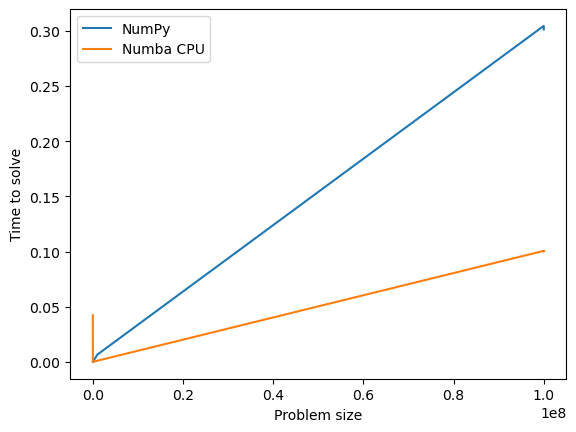

In [5]:
plt.xlabel("Problem size")
plt.ylabel("Time to solve")
plt.plot(sizes, numpy_times, label="NumPy")
plt.plot(sizes, numba_times, label="Numba CPU")
plt.legend()
plt.show()

### Generalized Universal Function

In order to write ufuncs that deal with multiple elements at a time and return arrays of different dimensions than the input (e.g. a moving average or a convolution), we can use the `@guvectorize` decorator.

The second argument of the decorator specifies the dimension of the input and output. For example, `(n),()->(n)` indicates the input will be an array of size n `(n)` and a scalar `()`, and the output will be an array of size n `(n)`.

`@guvectorize` functions, unlike `@vectorize`, don't return their output values, but instead writes the output to one of its arguments (allows return values of different dimensions).

In [6]:
@guvectorize(["void(float64[:], intp[:], float64[:])"], "(n),()->(n)")
def rolling_mean(in_arr, window_width, out_arr):
    # Unwrap scalar, which is contained in a 1-element array
    window_width = window_width[0]

    # Initialize variables for storage
    window_sum = 0.0
    count = 0

    # Populate first window_width means
    for i in range(window_width):
        window_sum += in_arr[i]
        count += 1
        out_arr[i] = window_sum / count

    # Populate means with complete windows
    for j in range(window_width, len(in_arr)):
        # add values that came into the window & subtract values that left
        window_sum += in_arr[j] - in_arr[j-window_width]
        out_arr[j] = window_sum / count

In [7]:
test_arr = np.random.randint(0, 20, size=(5,5))
print("Input: ")
print(test_arr)
print("Output: ")
print(rolling_mean(test_arr, [2]))

Input: 
[[ 0 19  4  6 14]
 [13 18 17  7  8]
 [ 4  7  4 19  9]
 [11  4 16  7 16]
 [ 7 17  2  5  7]]
Output: 
[[ 0.   9.5 11.5  5.  10. ]
 [13.  15.5 17.5 12.   7.5]
 [ 4.   5.5  5.5 11.5 14. ]
 [11.   7.5 10.  11.5 11.5]
 [ 7.  12.   9.5  3.5  6. ]]


## Numba on the GPU

When using Numba on the GPU, using CuPy arrays is best.

Write just-in-time compiled kernels with Numba using the `@cuda.jit` decorator. 

Access thread position information using the following:
* `cuda.grid(ndim)` returns absolute position of current thread in entire grid of blocks, given `ndim` is the number of dimensions the kernel was instantiated with.
* `cuda.gridSize(ndim)` returns absolute size(shape) of the entire grid of blocks, in units of threads, given `ndim` is the number of dimensions the kernel was instantiated with.

In [8]:
@cuda.jit
def numba_double(x):
    start = cuda.grid(1)
    step = cuda.gridsize(1)

    for i in range(start, x.shape[0], step):
        x[i] = 2*x[i]

When we call the JIT kernel, we have to specify the `[blocks_per_grid, threads_per_block]`.

Compare the performances of CPU NumPy, CPU Numba + NumPy, and GPU Numba + CuPy.

Note: You may get a performance warning due to using a Numba CUDA kernel with Numpy. Since we're comparing performance, ignore the warning and rerun the cell.

In [9]:
sizes = [2**12, 2**13, 2**14, 2**15, 2**16, 2**17, 2**18, 2**19, 2**20, 2**21]
numpy_times = []
numba_numpy_times = []
numba_cupy_times = []

for size in sizes:
    x_cpu = np.random.randn(size)
    x_gpu = cp.asarray(x_cpu)

    threads_per_block = 32
    blocks_per_grid = (x_cpu.size + threads_per_block - 1) // threads_per_block

    # CPU NumPy time
    start = time.perf_counter()
    output = x_cpu*2
    numpy_times.append(time.perf_counter() - start)

    # CPU Numba + NumPy time
    start = time.perf_counter()
    numba_double[blocks_per_grid, threads_per_block](x_cpu)
    numba_numpy_times.append(time.perf_counter() - start)

    # GPU Numba + CuPy time
    start = time.perf_counter()
    numba_double[blocks_per_grid, threads_per_block](x_gpu)
    numba_cupy_times.append(time.perf_counter() - start)

LinkerError: [222] Call to cuLinkAddData results in CUDA_ERROR_UNSUPPORTED_PTX_VERSION
ptxas application ptx input, line 9; fatal   : Unsupported .version 8.8; current version is '8.5'

ValueError: x and y must have same first dimension, but have shapes (10,) and (1,)

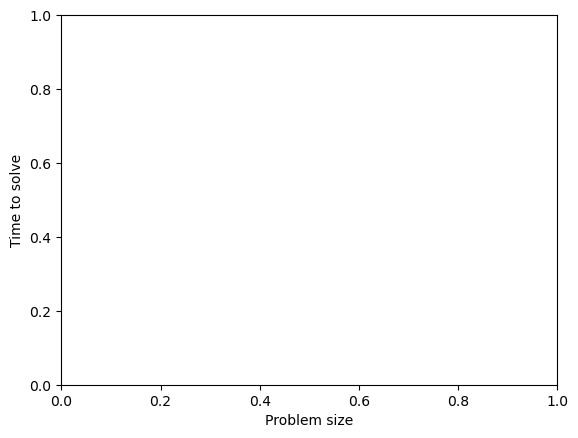

In [10]:
plt.xlabel("Problem size")
plt.ylabel("Time to solve")
plt.plot(sizes, numpy_times, label="NumPy")
plt.plot(sizes, numba_numpy_times, label="Numba CPU")
plt.plot(sizes, numba_cupy_times, label="Numba GPU")
plt.legend()
plt.show()

Here is an example of matrix multiplication, made faster by using shared memory.

`cuda.threadIdx.x` gives the thread indices in the current thread block (in the range \[0, `cuda.blockDim`\]).

In [5]:
# Computation will be done on blocks of threads_per_block x threads_per_block elements.

@cuda.jit
def fast_matmul(A, B, C):
    # Define arrays in the shared memory (size & type must be known at compile time)
    sA = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float64)
    sB = cuda.shared.array(shape=(threads_per_block, threads_per_block), dtype=float64)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    blocks_per_grid = cuda.gridDim.x

    # Quit if (x, y) is outside of valid C boundary
    if x >= C.shape[0] and y >= C.shape[1]:
        return

    # Each thread computes one element in the result matrix.
    # The dot product is chunked into dot products of threads_per_block-length vectors.
    tmp = float64(0.)
    for i in range(blocks_per_grid):
        # Preload data into shared memory
        sA[tx, ty] = A[x, ty + i * threads_per_block]
        sB[tx, ty] = B[tx + i * threads_per_block, y]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Computes partial product on the shared memory
        for j in range(threads_per_block):
            tmp += sA[tx, j] * sB[j, ty]

        # Wait until all threads finish computing
        cuda.syncthreads()

    C[x, y] = tmp

## Cleanup

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)